**Řešíme 2D úlohu konekce:**
$$\begin{align*}
    \frac{\partial u}{\partial t} + \beta \frac{\partial u}{\partial x} &= 0, \quad x \in [0, 2\pi],\,t\in[0, 1] \\
    u(x, 0) &= \sin(x) + \cos(x) \\
    u(0, t) &= u(2\pi, t),
\end{align*}$$
kde $\beta > 0$ je koeficient konvekce. Analytické řešení je
$$\begin{equation*}
    u(x, t) = \sin(x - \beta t) + \cos(x - \beta t).
\end{equation*}$$
Níže natrénujeme model řešící tuto úlohu, a poté jej porovnáme se správným řešením úlohy.

In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
# Zakladni importy
import torch
from torch.optim.lr_scheduler import StepLR
import numpy as np
import sys

In [62]:
# Import vlastnich modulu
sys.path.append("..")
import src.data.square_domain as sq
from src.models.mlp_model import MLPModel
from src import train
from src import calculus as calc
from src import utils

In [63]:
# Volba spravneho device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [64]:
# Definice ztratove funkce

BETA = 30 # BETA -- konstanta konvekce

# BETA neni argument funkce, protoze kazdy trenovaci algoritmus ocekava, ze 
# jako argument jen a pouze model a domena.
def loss_fn(model: torch.nn.Module, domain: sq.SquareDomain) -> torch.Tensor:
    _, u_x, u_t = calc.compute_derivatives_2d(model, domain.interior)
    pde_loss = torch.mean((u_t + BETA * u_x)**2)

    u_bottom = model(domain.bottom_boundary)
    left_loss = torch.mean((u_bottom - torch.sin(domain.bottom_boundary[:, 0:1]) 
                            - torch.cos(domain.bottom_boundary[:, 0:1]))**2)

    u_left = model(domain.left_boundary)
    u_right = model(domain.right_boundary)
    top_bot_loss = torch.mean((u_left - u_right)**2)

    return pde_loss + left_loss + top_bot_loss


In [65]:
# Definice modelu, domeny problemu a optimalizatoru
config = sq.SquareDomainConfig(
    x_0=0,
    x_1=2*np.pi,
    y_0=0,
    y_1=1,
    mirror_right_left=True,
    device=device
)

model = MLPModel(2, 1, [20, 20, 20]).to(device)
domain = sq.SquareDomain(config)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, eps=0.001, amsgrad=True)
scheduler = StepLR(optimizer=optimizer, step_size=10_000, gamma=0.1)

In [ ]:
# Trenujeme algoritmus a ukladame hodnoty ztraty
context = train.TrainingContext(
    model=model,
    optimizer=optimizer,
    domain=domain,
    loss_fn=loss_fn,
    epochs=2_000
)

TARGET_BETA = 30

# Postupne zvedam hodnotu BETA. Udajne to ma zlepsit konvergenci, ale nevim jak to spravne implementovat...
for i in np.arange(0, 1, 0.01):
    BETA = i * TARGET_BETA
    print(f"Current BETA value: {BETA}")
    loss_values = train.simple_train(context)

Current BETA value: 0.0
Loss at epoch 1 is: 1.0432460308074951
Loss at epoch 100 is: 0.6319262385368347
Loss at epoch 200 is: 0.032999131828546524
Loss at epoch 300 is: 0.012927023693919182
Loss at epoch 400 is: 0.0053904978558421135
Loss at epoch 500 is: 0.00284992391243577
Loss at epoch 600 is: 0.0016419746680185199
Loss at epoch 700 is: 0.0012488586362451315
Loss at epoch 800 is: 0.0010199177777394652
Loss at epoch 900 is: 0.0019766823388636112
Loss at epoch 1000 is: 0.0007925562094897032
Loss at epoch 1100 is: 0.0007592858746647835
Loss at epoch 1200 is: 0.0006924949120730162
Loss at epoch 1300 is: 0.0006506300414912403
Loss at epoch 1400 is: 0.0007577886572107673
Loss at epoch 1500 is: 0.0006001704023219645
Loss at epoch 1600 is: 0.0005552440416067839
Loss at epoch 1700 is: 0.0005335253081284463
Loss at epoch 1800 is: 0.0005172258242964745
Loss at epoch 1900 is: 0.0004929431597702205
Loss at epoch 2000 is: 0.00048519065603613853
Current BETA value: 0.3
Loss at epoch 1 is: 0.090679

/home/berva/Projects/PINNs/Introduction/notebooks/../src/utils.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels)


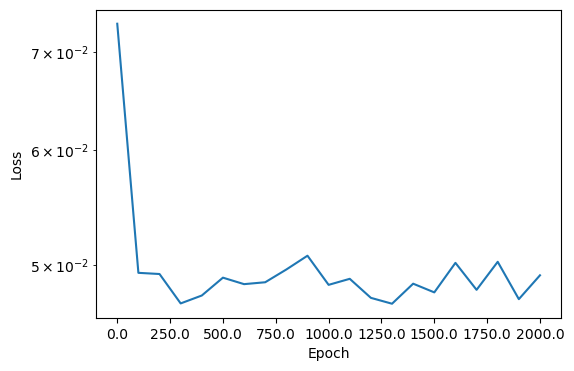

In [67]:
# Vykresleni ztraty
utils.plot_loss_values(loss_values, "Epoch", "Loss")

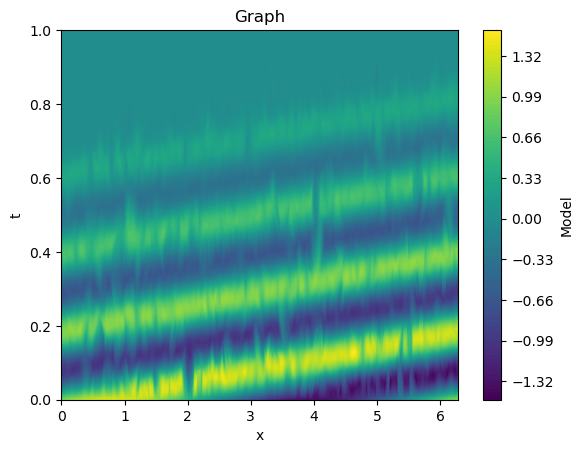

In [ ]:
# Vykresleni priblizneho reseni
utils.plot_function_on_domain(function=model, domain=domain, function_name='Model',
                              x_label='x', y_lable='t', N=2_000)

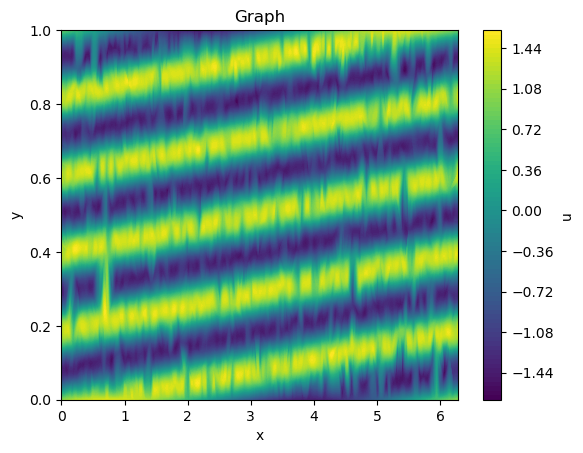

In [69]:
# Vykresleni skutecneho reseni
def solution(x: torch.Tensor) -> torch.Tensor:
    return torch.sin(x[:, 0:1] - BETA * x[:, 1:2]) + torch.cos(x[:, 0:1] - BETA * x[:, 1:2])

BETA

utils.plot_function_on_domain(function=solution, domain=domain, N=2_000)